In [1]:
#default ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as sk
#tf libraries
import tensorflow as tf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import itertools
import pandas as pd
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the test.csv file
train = pd.read_csv('train.csv')
print(train.head())

   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0              

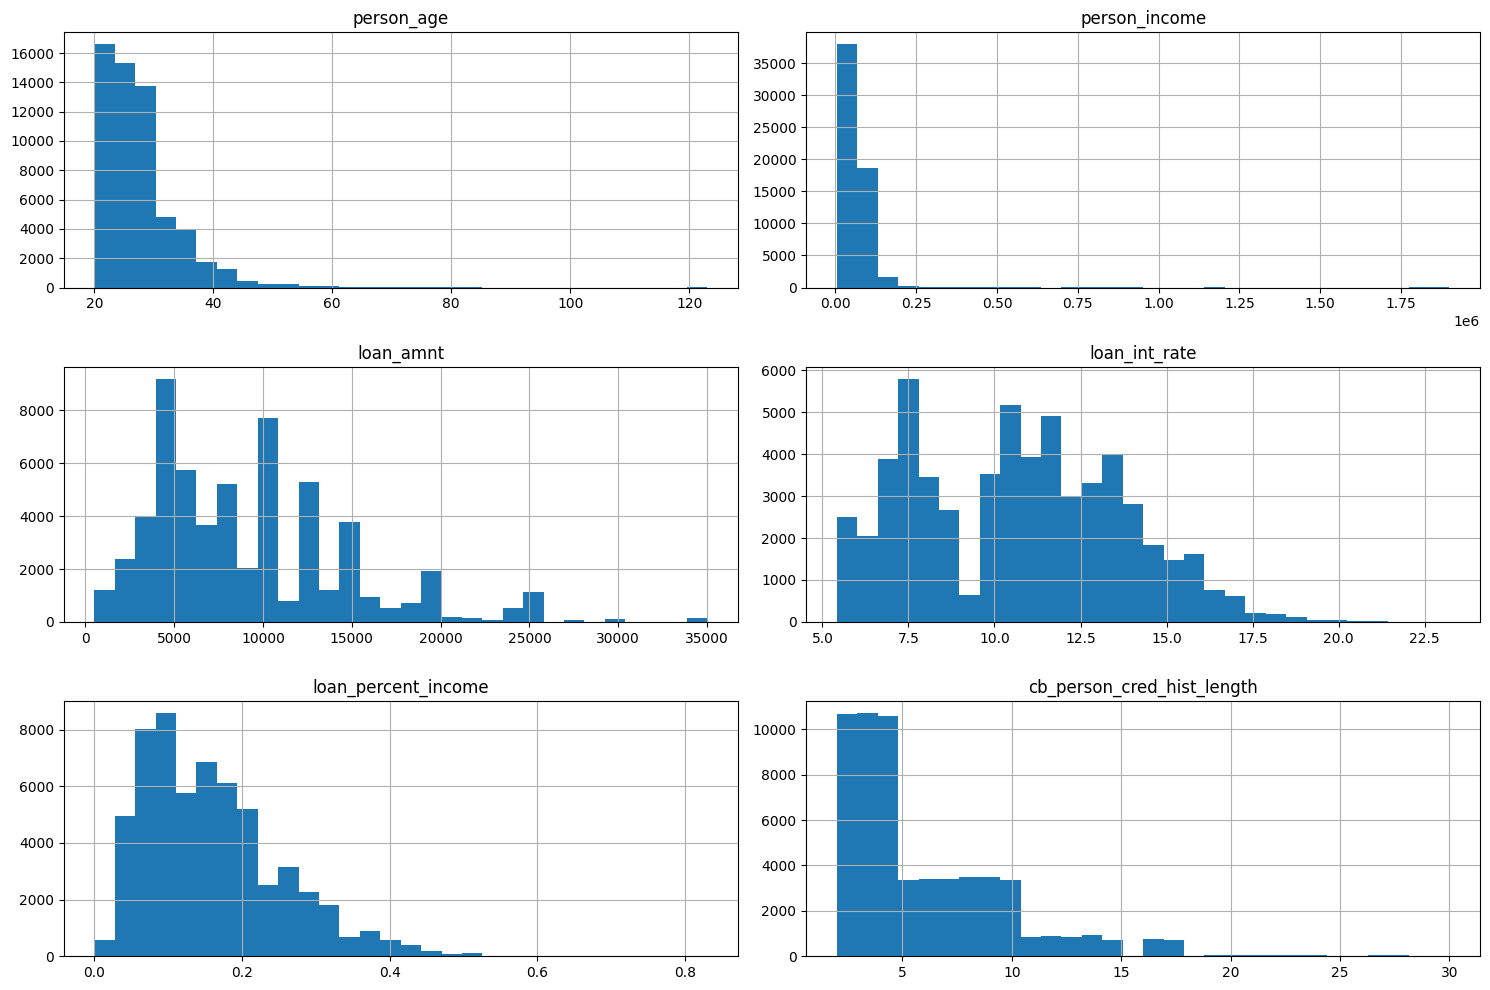

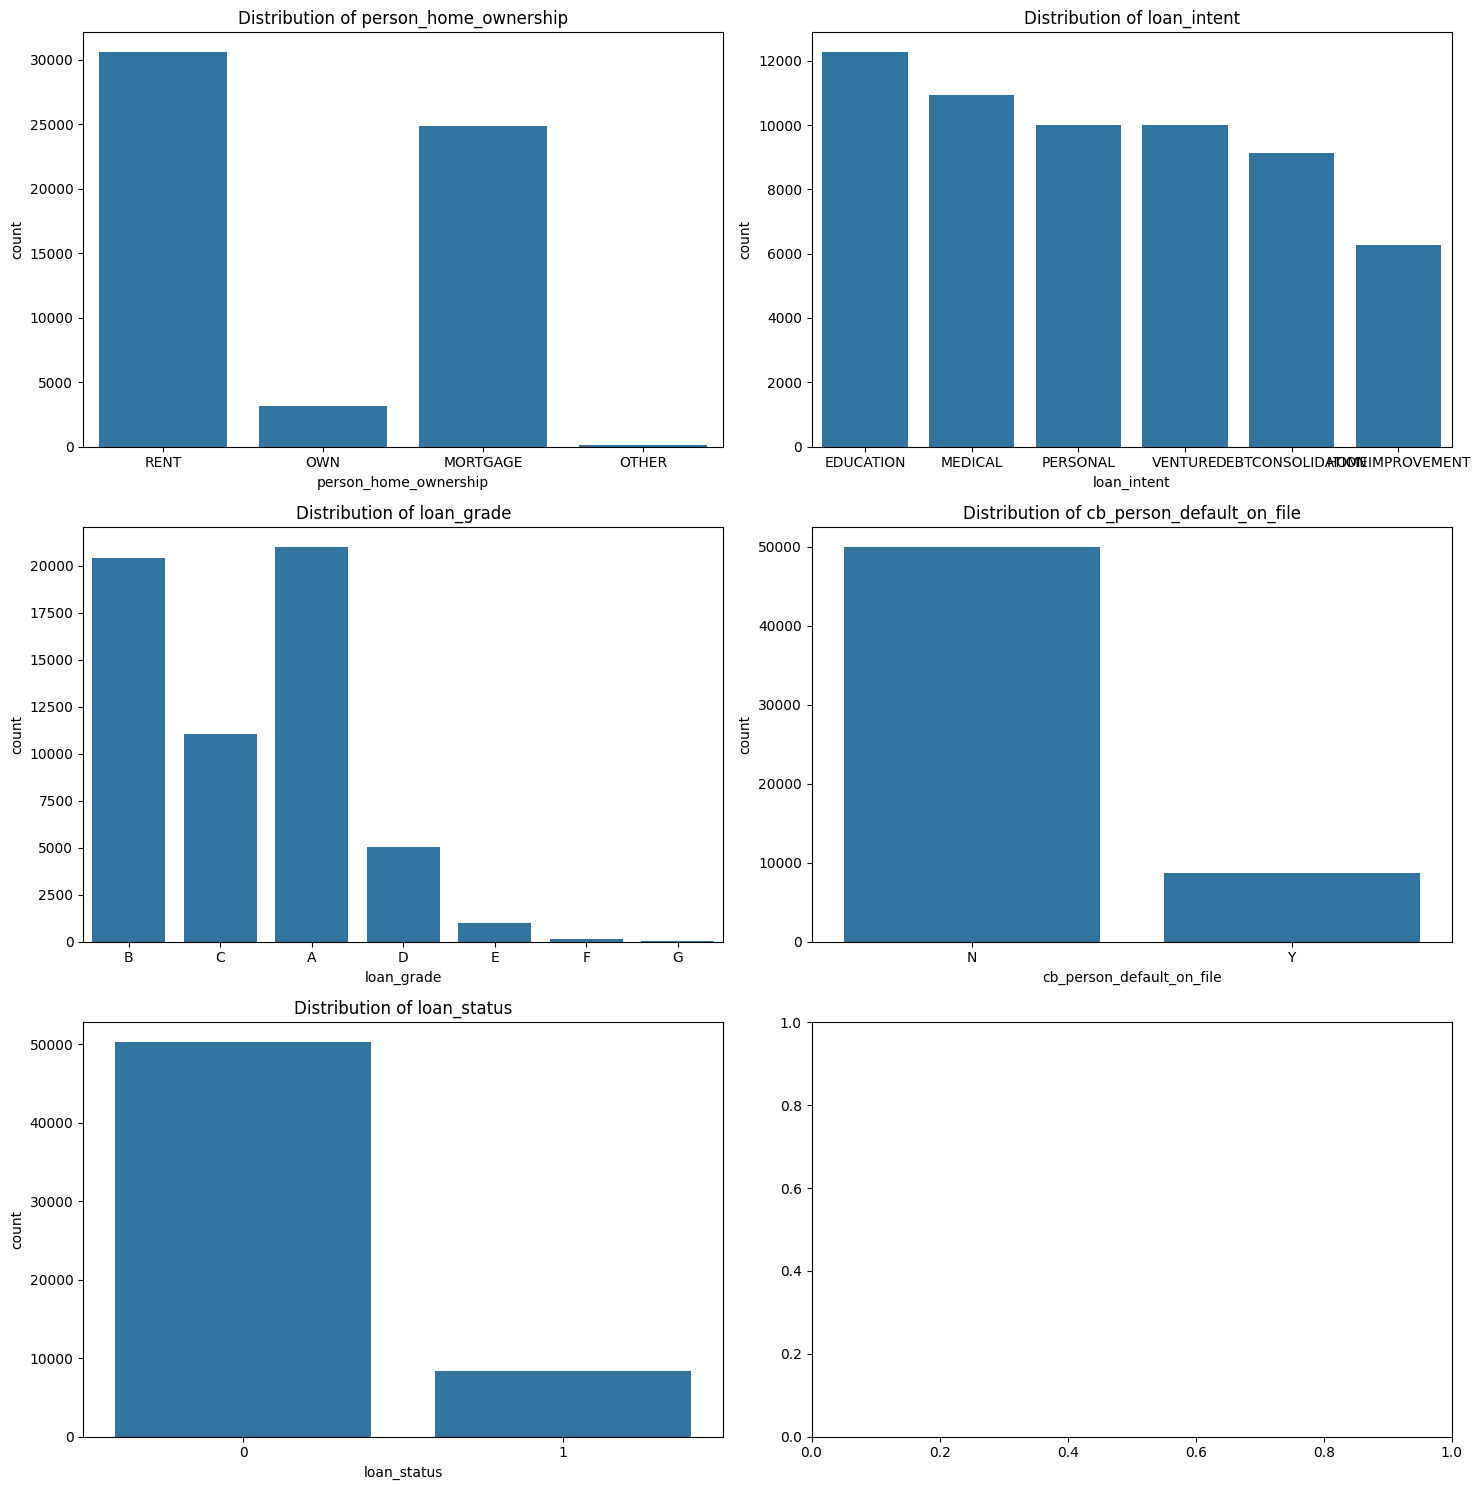

In [3]:


# Plot histograms for numerical columns
numerical_columns = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
train[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Plot count plots for categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_status']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Adjusted to 3x2 grid
for ax, col in zip(axes.flatten(), categorical_columns):
    sns.countplot(data=train, x=col, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [4]:


# Define the features and target
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
target = ['loan_status']  # Replace with the actual target column name

# Preprocess the data
X = train[features]
y = train[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the preprocessing for numerical and categorical features
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


print(X_test.shape)
print(y_test.head())
print(y_test.shape)
print(y_train.head())
print(y_train.shape)
print(X_train.shape)
# Hardcoded array


(17594, 26)
       loan_status
4657             0
56440            0
42117            1
10849            0
39395            0
(17594, 1)
       loan_status
52748            0
7648             0
4217             1
37793            0
28209            1
(41051, 1)
(41051, 26)


In [5]:
# Print the shapes of the datasets
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

# Print the first few rows of y_test and y_train without indices
print('y_test values:')
print(y_test.values[:5])

print('y_train values:')
print(y_train.values[:5])

X_test shape: (17594, 26)
y_test shape: (17594, 1)
X_train shape: (41051, 26)
y_train shape: (41051, 1)
y_test values:
[[0]
 [0]
 [1]
 [0]
 [0]]
y_train values:
[[0]
 [0]
 [1]
 [0]
 [1]]


In [6]:
class CustomModel:
    def __init__(self, layer_sizes):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
        
        for units in reversed(sorted(layer_sizes)):
            self.model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        self.model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    def fit(self, X_train, y_train, X_test, y_test, epochs=1,verbose=0,batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose,batch_size=batch_size)
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, verbose=0)
    
    def predict(self, X_test):
        y_pred_prob = self.model.predict(X_test)
        return (y_pred_prob > 0.5).astype(int)
    
    def summary(self):
        self.model.summary()

In [7]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score, r2_score
import gc
# Assuming CustomModel class and other necessary code is already defined

array = [256, 128, 64, 32, 16, 8, 4]

# batch_sizes = [16, 32, 64]
# epoch_values = [1, 5, 10]
batch_sizes = [32] 
epoch_values = [5]
# Generate the power set of the array
# power_set = list(itertools.chain.from_iterable(itertools.combinations(array, r) for r in range(1, len(array) + 1)))
power_set = [[512,256, 128, 64, 32, 16, 8, 4],[512,256, 128, 64, 32, 16, 8],
             [512,256, 128, 64, 32, 16],[512,256, 128, 64, 32],[512,256, 128, 64],
             [512,256, 128],[512,256],[512]]
# Initialize variables to keep track of the best model
best_model = None
best_roc_auc = 0

# Loop to add layers, batch sizes, and epochs, and evaluate the model
for subset in power_set:
    for batch_size in batch_sizes:
        for epochs in epoch_values:
            custom_model = CustomModel(subset)
            
            # Train the model
            custom_model.fit(X_train, y_train, X_test, y_test, epochs=epochs, batch_size=batch_size)
            
            # Evaluate the model
            loss, accuracy = custom_model.evaluate(X_test, y_test)
            
            # Predict probabilities for the test set
            y_pred = custom_model.predict(X_test)
            
            # Calculate the ROC AUC score
            roc_auc = roc_auc_score(y_test, y_pred)
            
            # Calculate the R² score
            r2 = r2_score(y_test, y_pred)
            
            # Print the metrics
            print(f'Layers: {subset}, Batch Size: {batch_size}, Epochs: {epochs}')
            print(f'  Loss: {loss}')
            print(f'  Accuracy: {accuracy}')
            print(f'  ROC AUC: {roc_auc}')
            print(f'  R² score: {r2}')
            
            # Check if this model is the best so far
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_model = custom_model
                custom_model.model.save("bm.keras")
            gc.collect()

# Print the best model summary
print("Best Model Summary:")
best_model.summary()

C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Layers: [512, 256, 128, 64, 32, 16, 8, 4], Batch Size: 32, Epochs: 5
  Loss: 0.18468360602855682
  Accuracy: 0.9424235820770264
  ROC AUC: 0.847160191506419
  R² score: 0.5225754124564892


C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step
Layers: [512, 256, 128, 64, 32, 16, 8], Batch Size: 32, Epochs: 5
  Loss: 0.18462690711021423
  Accuracy: 0.9452654123306274
  ROC AUC: 0.8260949461583744
  R² score: 0.546140298317472


C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step
Layers: [512, 256, 128, 64, 32, 16], Batch Size: 32, Epochs: 5
  Loss: 0.17452089488506317
  Accuracy: 0.9474252462387085
  ROC AUC: 0.8393882258825969
  R² score: 0.5640496115718189


C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step
Layers: [512, 256, 128, 64, 32], Batch Size: 32, Epochs: 5
  Loss: 0.17821547389030457
  Accuracy: 0.944753885269165
  ROC AUC: 0.8254583701124493
  R² score: 0.5418986188624951


C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step
Layers: [512, 256, 128, 64], Batch Size: 32, Epochs: 5
  Loss: 0.18001362681388855
  Accuracy: 0.946629524230957
  ROC AUC: 0.8392645216164767
  R² score: 0.5574514435307437


C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step
Layers: [512, 256, 128], Batch Size: 32, Epochs: 5
  Loss: 0.1802929937839508
  Accuracy: 0.9459474682807922
  ROC AUC: 0.8395460037360939
  R² score: 0.5517958709241079


C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step
Layers: [512, 256], Batch Size: 32, Epochs: 5
  Loss: 0.17784954607486725
  Accuracy: 0.9456064701080322
  ROC AUC: 0.8274800428427144
  R² score: 0.5489680846207899


C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step
Layers: [512], Batch Size: 32, Epochs: 5
  Loss: 0.1803061068058014
  Accuracy: 0.9456064701080322
  ROC AUC: 0.8442642580283479
  R² score: 0.5489680846207899
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,269 (2.16 MB)

 Trainable params: 189,089 (738.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 378,180 (1.44 MB)

550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Number of predictions equal to 0: 15521
Number of predictions equal to 1: 2073


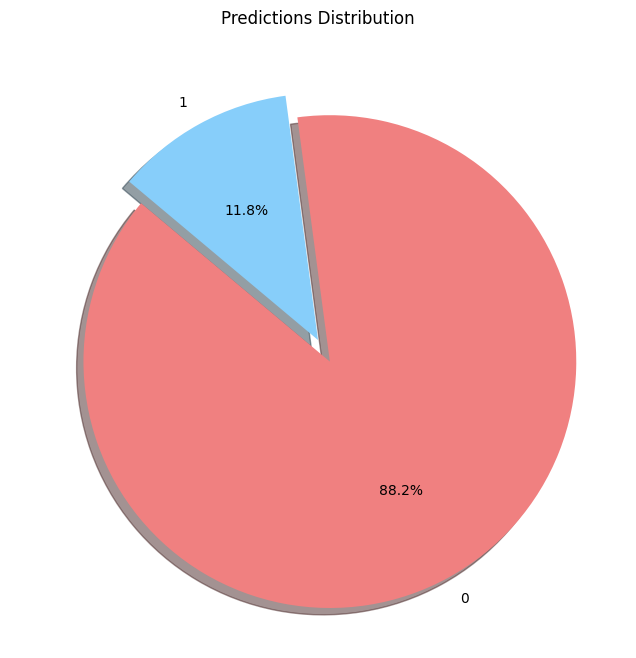

In [8]:


# Predict the values using the best model
y_pred = best_model.predict(X_test)
print(y_pred)

# Count the number of predictions that are 0 and 1
count_0 = (y_pred == 0).sum()
count_1 = (y_pred == 1).sum()

# Print the counts
print(f'Number of predictions equal to 0: {count_0}')
print(f'Number of predictions equal to 1: {count_1}')

# Create a pie chart
labels = ['0', '1']
sizes = [count_0, count_1]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

Confusion Matrix:
[[14817   309]
 [  704  1764]]


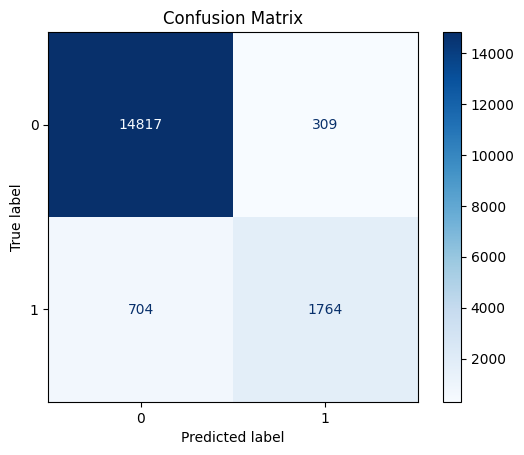

R² score: 0.5225754124564892
Best ROC AUC score: 0.847160191506419


In [9]:
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the R² score
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

# Print the best ROC AUC score
print(f'Best ROC AUC score: {best_roc_auc}')

In [ ]:
#load model from bm.keras and predict and find r2 rocaucscore and confusion matrix for x_test and y_test

import tensorflow as tf
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix
import pandas as pd

# Load the model from bm.keras
model = tf.keras.models.load_model('bm.keras')

# Predict on the test data
y_pred_prob = model.predict(X_test)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f'R² Score: {r2}')
print(f'ROC AUC Score: {roc_auc}')
print('Confusion Matrix:')
print(conf_matrix)

      id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                         

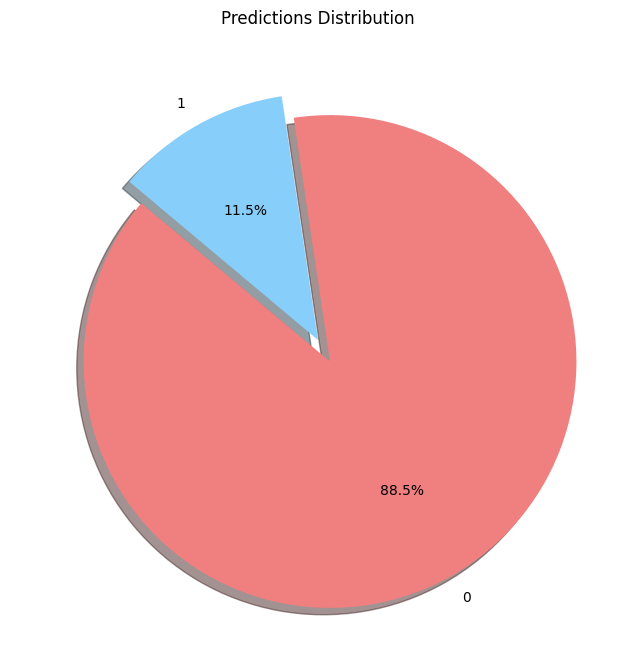

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data
X = preprocessor.transform(X)

# Predict the values using the model

# Clip the predictions to 0 or 1 based on the threshold of 0.5
y_pred = best_model.predict(X)
# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()